<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

In [1]:
"""
Import Statements
"""
from collections import Counter
import re
 
import pandas as pd
import numpy as np

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS

nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

In [2]:
df_path = './data/yelp_coffeeshop_review_data.csv'

shops = pd.read_csv(df_path)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [3]:
# Strip down & tokenize
def tokenize(text):
    """Parses a string into a list of semantic units (words)

    Args:
        text (str): The string that the function will tokenize.

    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    
    tokens = re.sub(r'[^a-zA-Z ^0-9]', '', text)
    tokens = tokens.lower().split()
    
    return tokens

shops['tokens'] = shops['full_review_text'].apply(tokenize)

In [4]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,tokens
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating,"[11252016, 1, checkin, love, love, loved, the,..."
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating,"[1222016, listed, in, date, night, austin, amb..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating,"[11302016, 1, checkin, listed, in, brunch, spo..."
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating,"[11252016, very, cool, decor, good, drinks, ni..."
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating,"[1232016, 1, checkin, they, are, located, with..."


In [5]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [6]:
wc = count(shops['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
28,the,6847,34809,1.0,0.044537,0.044537,0.899028
49,and,6864,26650,2.0,0.034098,0.078634,0.901261
21,a,6246,22755,3.0,0.029114,0.107748,0.820116
37,i,5528,20237,4.0,0.025892,0.133641,0.725840
18,to,5653,17164,5.0,0.021961,0.155601,0.742253


In [7]:
# Tokenizer Pipe
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False) & (token.is_space == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

shops['tokens'] = tokens

In [8]:
shops.tokens.head()

0    [11/25/2016, 1, check-in, love, love, loved, a...
1    [12/2/2016, listed, date, night:, austin,, amb...
2    [11/30/2016, 1, check-in, listed, brunch, spot...
3    [11/25/2016, cool, decor!, good, drinks, nice,...
4    [12/3/2016, 1, check-in, located, northcross, ...
Name: tokens, dtype: object

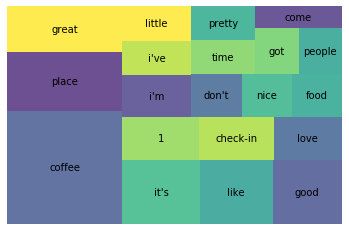

In [9]:
wc = count(shops['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [10]:
nlp_droplist = [' ', 'coffee','1', 'place', 'good', 'be', 'not', 'go']
stopwords = set(STOPWORDS.union(nlp_droplist))

In [11]:
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if (token.text.lower() not in stopwords) & (token.is_punct == False) \
        & (token.is_space == False):
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

In [14]:
wc = count(shops['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
93,great,2438,3250,1.0,0.008175,0.008175,0.320116
256,really,1636,2236,2.0,0.005624,0.013799,0.214811
316,one,1608,2093,3.0,0.005264,0.019063,0.211134
20,check-in,1957,1961,4.0,0.004932,0.023995,0.256959
31,love,1434,1806,5.0,0.004543,0.028538,0.188288


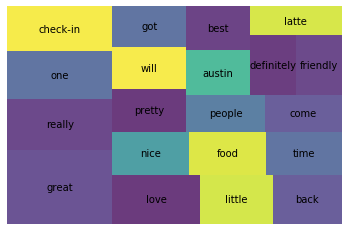

In [15]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

C:\Users\RevL\.conda\envs\U4-S1-NLP\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


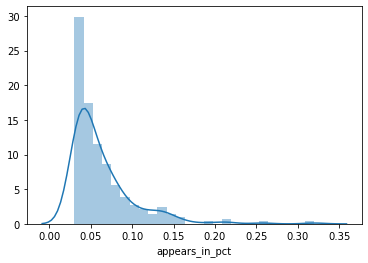

In [16]:
wc_perc = wc[wc['appears_in_pct'] >= 0.03]

sns.distplot(wc_perc['appears_in_pct']);

In [35]:
from wordcloud import STOPWORDS
nlp = spacy.load("en_core_web_lg")
# tokenizer = Tokenizer(nlp.vocab)
nlp_droplist = [' stopwords = set(STOPWORDS.union(nlp_droplist))
def get_lemmas(text):

    lemmas = []

    doc = nlp(text)

    for token in doc: 
        if (token.is_stop == False) and (token.text.lower() not in stopwords) and (token.is_punct == False) and (token.pos_ != 'PRON'):
                lemmas.append(token.lemma_)

    return lemmas

In [37]:
def get_lemmas2(text):

    lemmas = []
    
    doc = nlp(text)

    for token in doc:
        if (token.text.lower() not in stopwords):
            if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
                lemmas.append(token.lemma_)
    
# #     return lmas

In [36]:
def get_lemmas2(text):

    lemmas = []

    doc = nlp(text)

    for token in doc:
        if (token.text.lower() not in stopwords):
            if (token.is_stop == False) and (token.is_punct == False) and (token.pos_!= 'PRON'):
                lemmas.append(token.lemma_)

    return lemmas

In [37]:
shops['lemmas5'] = shops['full_review_text'].apply(get_lemmas2)

In [38]:
wc = count(shops['lemmas5'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
74,great,2843,3924,1.0,0.011391,0.011391,0.373293
30,check,3175,3468,2.0,0.010067,0.021458,0.416886
418,come,1932,2637,3.0,0.007655,0.029113,0.253676
490,time,1762,2382,4.0,0.006915,0.036028,0.231355
0,drink,1636,2339,5.0,0.006790,0.042818,0.214811


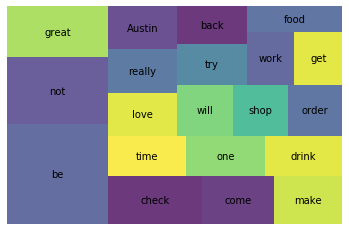

In [24]:
lemma_wc = count(shops['lemmas'])
lemma_wc_top20 = lemma_wc[lemma_wc['rank'] <= 20]

squarify.plot(sizes=lemma_wc_top20['pct_total'], label=lemma_wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [45]:
shops['star_rating'] = shops['star_rating'].map(lambda x: x.rstrip(' starrating.0'))
shops.head(3)

AttributeError: 'int' object has no attribute 'rstrip'

In [21]:
shops['star_rating'] = shops['star_rating'].astype('int32')
shops.dtypes

coffee_shop_name    object
full_review_text    object
star_rating          int32
tokens              object
lemmas              object
dtype: object

In [46]:
shops_good = shops[shops['star_rating'] > 3].copy()
shops_bad = shops[shops['star_rating'] < 4].copy()

In [47]:
shops_good.head(3)

,coffee_shop_name,full_review_text,star_rating,tokens,lemmas
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5,"[11/25/2016, check-in, love, love, loved, atmo...","[11/25/2016, check, love, love, love, atmosphe..."
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4,"[12/2/2016, listed, date, night:, austin,, amb...","[12/2/2016, list, Date, Night, Austin, Ambianc..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4,"[11/30/2016, check-in, listed, brunch, spots, ...","[11/30/2016, check, list, Brunch, Spots, love,..."


In [48]:
shops_bad.head(3)

,coffee_shop_name,full_review_text,star_rating,tokens,lemmas
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2,"[11/25/2016, cool, decor!, drinks, nice, seati...","[11/25/2016, cool, decor, drink, nice, seating..."
8,The Factory - Cafe With a Soul,"10/25/2016 1 check-in Ok, let's try this appr...",3,"[10/25/2016, check-in, ok,, try, approach..., ...","[10/25/2016, check, ok, let, try, approach, pr..."
11,The Factory - Cafe With a Soul,"11/20/2016 The store has A+ decoration, but h...",3,"[11/20/2016, store, a+, decoration,, honestly,...","[11/20/2016, store, A+, decoration, honestly, ..."


In [49]:
good_count = count(shops_good['lemmas'])
good_top20 = good_count[good_count['rank'] <= 20]

bad_count = count(shops_bad['lemmas'])
bad_top20 = bad_count[bad_count['rank'] <= 20]

In [50]:
good_top20.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
94,great,2497,3459,1.0,0.012847,0.012847,0.406678
25,check,2686,2941,2.0,0.010923,0.023770,0.437459
5,love,1586,2083,3.0,0.007736,0.031506,0.258306
53,Austin,1543,1986,4.0,0.007376,0.038882,0.251303
378,come,1480,1986,5.0,0.007376,0.046258,0.241042


In [27]:
def create_word_cloud(comment_df):
    comment_words = ' '

    for val in comment_df.word:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        for words in tokens:
            comment_words = comment_words + words + ' '
    
    return comment_words

In [51]:
glist = create_word_cloud(good_top20)
blist = create_word_cloud(bad_top20)

g_wordcloud = WordCloud(width = 1200, height = 1200,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(glist)

b_wordcloud = WordCloud(width = 1200, height = 1200,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(blist)

In [52]:
print('\n', glist, '\n', blist)


  great check love austin come time shop drink try work friendly get nice order food latte good delicious little tea  
  order come drink time check food great get go service try shop work taste $ people nice pretty want look 


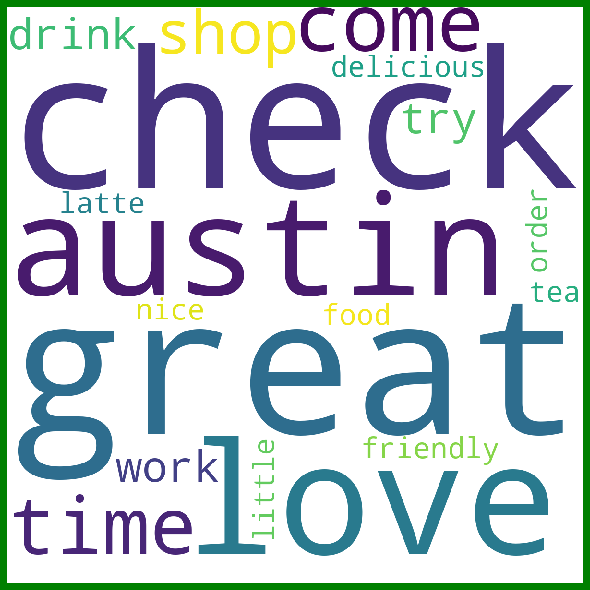

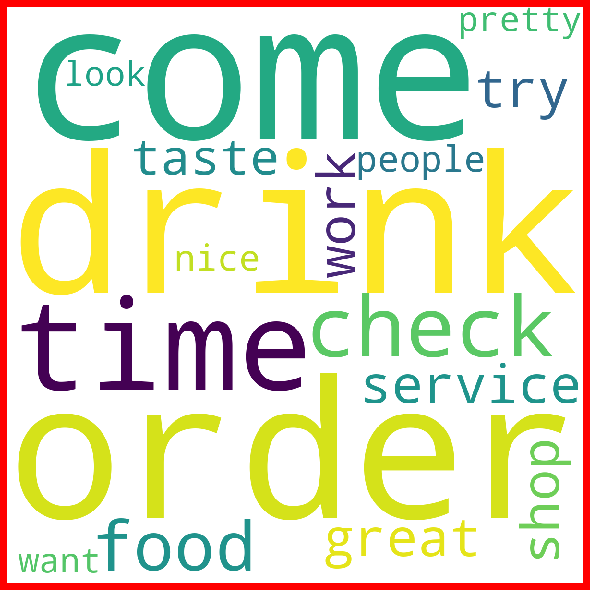

In [55]:
axs[0] = plt.figure(figsize = (8, 8), facecolor = 'Green') 
axs[0] = plt.imshow(g_wordcloud) 
axs[0] = plt.axis("off") 
axs[0] = plt.tight_layout(pad = 0)

axs[1] = plt.figure(figsize = (8, 8), facecolor = 'Red') 
axs[1] = plt.imshow(b_wordcloud) 
axs[1] = plt.axis("off") 
axs[1] = plt.tight_layout(pad = 0)

In [57]:
good_top20.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
94,great,2497,3459,1.0,0.012847,0.012847,0.406678
25,check,2686,2941,2.0,0.010923,0.023770,0.437459
5,love,1586,2083,3.0,0.007736,0.031506,0.258306
53,Austin,1543,1986,4.0,0.007376,0.038882,0.251303
378,come,1480,1986,5.0,0.007376,0.046258,0.241042


In [58]:
bad_top20.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
118,order,431,763,1.0,0.010141,0.010141,0.292005
43,come,452,651,2.0,0.008653,0.018794,0.306233
6,drink,363,610,3.0,0.008108,0.026902,0.245935
471,time,419,608,4.0,0.008081,0.034983,0.283875
160,check,489,527,5.0,0.007005,0.041988,0.331301


In [59]:
good_top20.rename(columns = {'appears_in':'appears_in_g'}, inplace = True)
bad_top20.rename(columns = {'appears_in':'appears_in_b'}, inplace = True)

C:\Users\RevL\.conda\envs\U4-S1-NLP\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [89]:
top20_df = pd.merge(good_top20, bad_top20, how='outer', suffixes=('_g','_b'), on='word')
top20_df.head()

,word,appears_in_g,count_g,rank_g,pct_total_g,cul_pct_total_g,appears_in_pct_g,appears_in_b,count_b,rank_b,pct_total_b,cul_pct_total_b,appears_in_pct_b
0,great,2497.0,3459.0,1.0,0.012847,0.012847,0.406678,346.0,465.0,7.0,0.006181,0.054788,0.234417
1,check,2686.0,2941.0,2.0,0.010923,0.023770,0.437459,489.0,527.0,5.0,0.007005,0.041988,0.331301
2,love,1586.0,2083.0,3.0,0.007736,0.031506,0.258306,NaN,NaN,NaN,NaN,NaN,NaN
3,Austin,1543.0,1986.0,4.0,0.007376,0.038882,0.251303,NaN,NaN,NaN,NaN,NaN,NaN
4,come,1480.0,1986.0,5.0,0.007376,0.046258,0.241042,452.0,651.0,2.0,0.008653,0.018794,0.306233


In [90]:
keep_cols = ['word', 'count_g', 'count_b']
ctdf = top20_df[keep_cols]

In [91]:
print(len(ctdf))
ctdf.head()

28


,word,count_g,count_b
0,great,3459.0,465.0
1,check,2941.0,527.0
2,love,2083.0,NaN
3,Austin,1986.0,NaN
4,come,1986.0,651.0


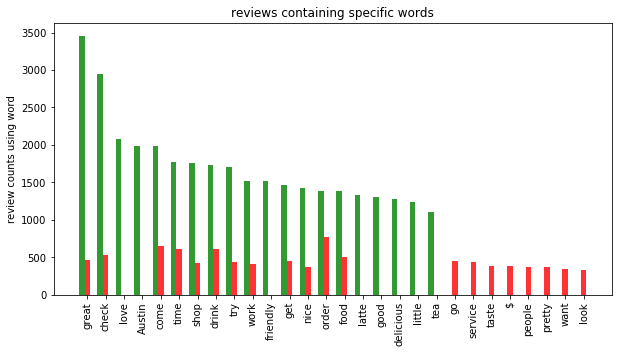

In [92]:
# data to plot
n_groups = len(ctdf)
g_counts = ctdf.count_g
b_counts = ctdf.count_b

# create plot
# fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8

plt.figure(figsize=(10, 5))

rects1 = plt.bar(index, g_counts, bar_width,
    alpha=opacity,
    color='g',
    label='good')

rects2 = plt.bar(index + bar_width, b_counts, bar_width,
    alpha=opacity,
    color='r',
    label='bad')

plt.xlabel('')
plt.ylabel('review counts using word')
plt.title('reviews containing specific words')
plt.xticks(index + bar_width, ctdf.word, rotation='vertical')
plt.legend().remove()

plt.show();